In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import OLS

In [252]:
# Load the data
file_path = "data/PSX/raw/train/data.csv"
training_data = pd.read_csv(
    file_path, parse_dates=[["YEAR", "MONTH", "DAY"]], index_col="YEAR_MONTH_DAY"
)
training_data.index.names = ["DATE"]

/tmp/ipykernel_13515/2088950581.py:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  training_data = pd.read_csv(


In [253]:
# Display the first few rows of the data
training_data.head()

,OPEN,HIGH,LOW,CLOSE,VOLUME
DATE,,,,,
2020-01-01,125.00,127.50,122.90,125.43,95800
2020-01-02,123.15,127.49,123.15,125.84,111600
2020-01-03,125.00,125.00,122.00,122.98,66600
2020-01-06,120.25,125.00,117.10,119.28,108600
2020-01-07,122.00,123.50,113.32,119.26,416300


In [254]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 992 entries, 2020-01-01 to 2023-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   OPEN    992 non-null    float64
 1   HIGH    992 non-null    float64
 2   LOW     992 non-null    float64
 3   CLOSE   992 non-null    float64
 4   VOLUME  992 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 46.5 KB


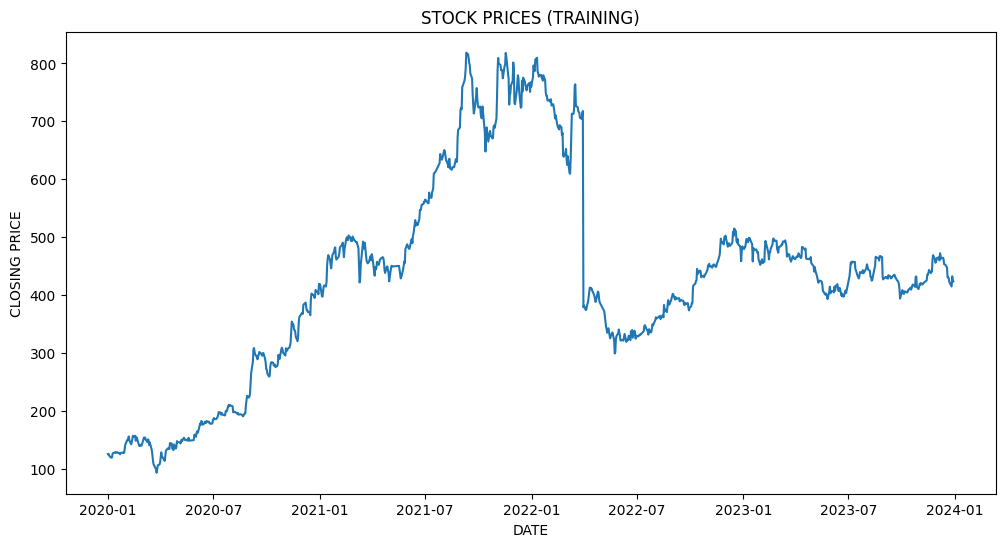

In [255]:
# Plot the 'Close' prices
plt.figure(figsize=(12, 6))
plt.plot(training_data["CLOSE"])
plt.title("STOCK PRICES (TRAINING)")
plt.xlabel("DATE")
plt.ylabel("CLOSING PRICE")
plt.show()

In [256]:
# Load the data
file_path = "data/PSX/raw/test/data.csv"
testing_data = pd.read_csv(
    file_path, parse_dates=[["YEAR", "MONTH", "DAY"]], index_col="YEAR_MONTH_DAY"
)
testing_data.index.names = ["DATE"]

/tmp/ipykernel_13515/1094089370.py:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  testing_data = pd.read_csv(


In [257]:
# Display the first few rows of the data
testing_data.head()

,OPEN,HIGH,LOW,CLOSE,VOLUME
DATE,,,,,
2024-01-01,426.0,449.5,424.89,447.75,483450
2024-01-02,445.0,449.9,437.00,441.08,197802
2024-01-03,441.0,442.2,436.50,437.13,233563
2024-01-04,437.0,438.0,430.00,431.79,152811
2024-01-05,431.0,434.0,420.00,430.54,150448


In [258]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119 entries, 2024-01-01 to 2024-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   OPEN    119 non-null    float64
 1   HIGH    119 non-null    float64
 2   LOW     119 non-null    float64
 3   CLOSE   119 non-null    float64
 4   VOLUME  119 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 5.6 KB


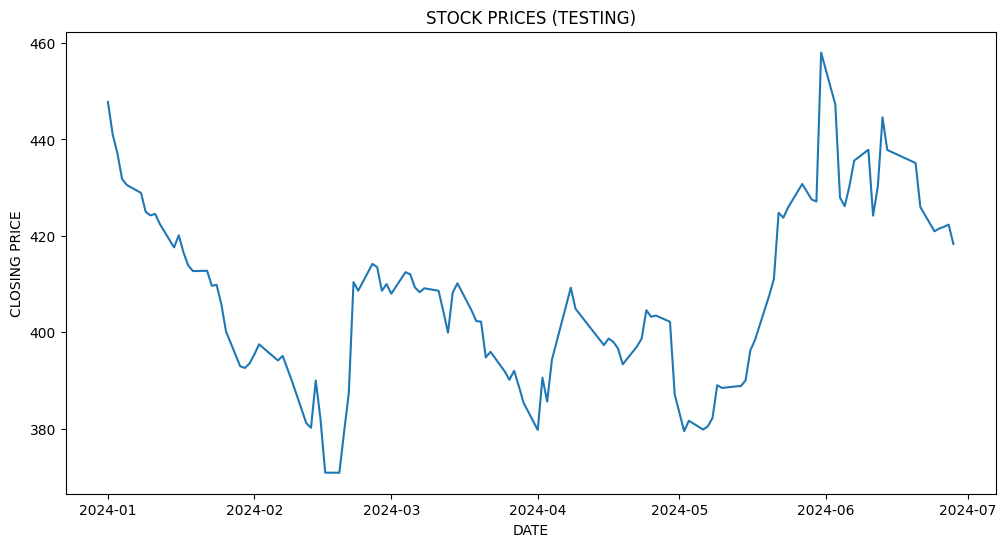

In [259]:
# Plot the 'Close' prices
plt.figure(figsize=(12, 6))
plt.plot(testing_data["CLOSE"])
plt.title("STOCK PRICES (TESTING)")
plt.xlabel("DATE")
plt.ylabel("CLOSING PRICE")
plt.show()

In [260]:
# Perform Augmented Dickey-Fuller test
result = adfuller(training_data["CLOSE"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.9323378818361436
p-value: 0.3170045605518597


In [261]:
class ARIMA:
    def __init__(self, data, p, d, q):
        self.data = data
        self.p = p
        self.d = d
        self.q = q

    def fit(self):
        # Differencing
        diff_data = self.data
        for _ in range(self.d):
            diff_data = diff_data.diff().dropna()

        plot_acf(self.data)
        plot_pacf(self.data)
        plt.show()

        # AR part (using OLS regression)
        X = np.column_stack([diff_data.shift(i) for i in range(1, self.p + 1)])
        X = X[self.p :]
        y = diff_data[self.p :]
        self.model_ar = OLS(y, X).fit()

        # MA part (using residuals)
        self.residuals = y - self.model_ar.predict(X)
        self.residuals = self.residuals[self.q :]

        X_residuals = np.column_stack(
            [self.residuals.shift(i) for i in range(1, self.q + 1)]
        )
        X_residuals = X_residuals[self.q :]
        y_residuals = self.residuals[self.q :]

        self.model_ma = OLS(y_residuals, X_residuals).fit()

    def predict(self, steps):
        # Make predictions
        predictions = []
        last_data = self.data[-self.p :]
        for _ in range(steps):
            ar_part = np.dot(self.model_ar.params, last_data[-self.p :])
            ma_part = np.dot(self.model_ma.params, self.residuals[-self.q :])
            prediction = ar_part + ma_part
            predictions.append(prediction)

            # Update data for next prediction
            last_data = np.append(last_data, prediction)
            self.residuals = np.append(self.residuals, prediction - ar_part)

        return predictions

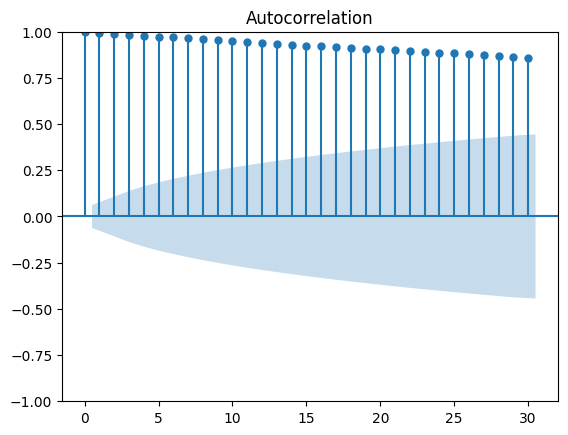

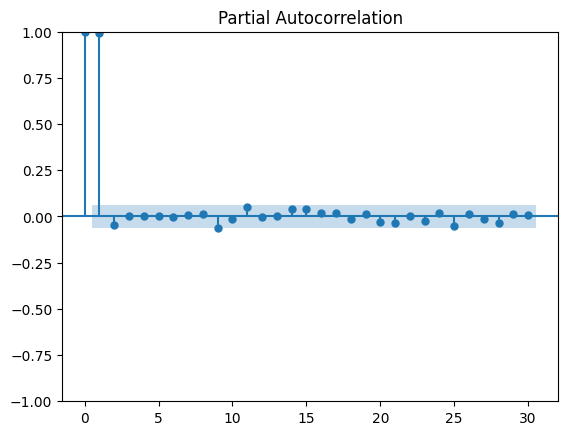

In [262]:
# Fit the model
arima = ARIMA(training_data["CLOSE"], p=1, d=1, q=356)
arima.fit()

In [263]:
steps = 182
pred_dates = pd.date_range(start=training_data.index[-1] + pd.Timedelta(days=1), periods=steps)

In [264]:
# Make predictions
predictions = arima.predict(steps=steps)
[float(p) for p in predictions]

[20.877063549544935,
 3.1371884019735665,
 -11.332203843544482,
 -10.610680146002304,
 -5.695207511969766,
 3.1592559211037665,
 7.244983835245105,
 -4.22514494775938,
 -3.6265756967571834,
 5.618167261929324,
 -4.864837850859871,
 6.647694816855939,
 6.568163664695222,
 -4.1635772744631785,
 1.280824057026492,
 7.080445933723181,
 -1.5664053966432323,
 -5.3122836304476095,
 -4.644169156249122,
 24.204292550968635,
 7.363733130257861,
 -15.648291573023595,
 -2.9060231618970933,
 -7.201562683604437,
 -13.109356163834509,
 9.167398519441855,
 -3.323735389304411,
 -12.41201199313373,
 -4.515240784715566,
 -1.5697761794759861,
 6.377909272871919,
 6.939196786795873,
 -6.926242928110471,
 -9.945287544125664,
 5.773199029128532,
 -6.07222820909727,
 -2.8198807994052704,
 -7.35237037403453,
 -1.5951921153484354,
 12.359130284415656,
 -11.40732645856999,
 -5.933734639529343,
 7.91424869414306,
 -2.392390643046331,
 -0.6396565738322086,
 4.6592685599679715,
 1.4946352181904794,
 -0.739279801747

In [265]:
predictions = pd.Series(predictions, index=pred_dates)
predictions


2023-12-30    20.877064
2023-12-31     3.137188
2024-01-01   -11.332204
2024-01-02   -10.610680
2024-01-03    -5.695208
                ...    
2024-06-24     3.678093
2024-06-25     5.171047
2024-06-26    -5.575753
2024-06-27     5.727264
2024-06-28     2.185687
Freq: D, Length: 182, dtype: float64

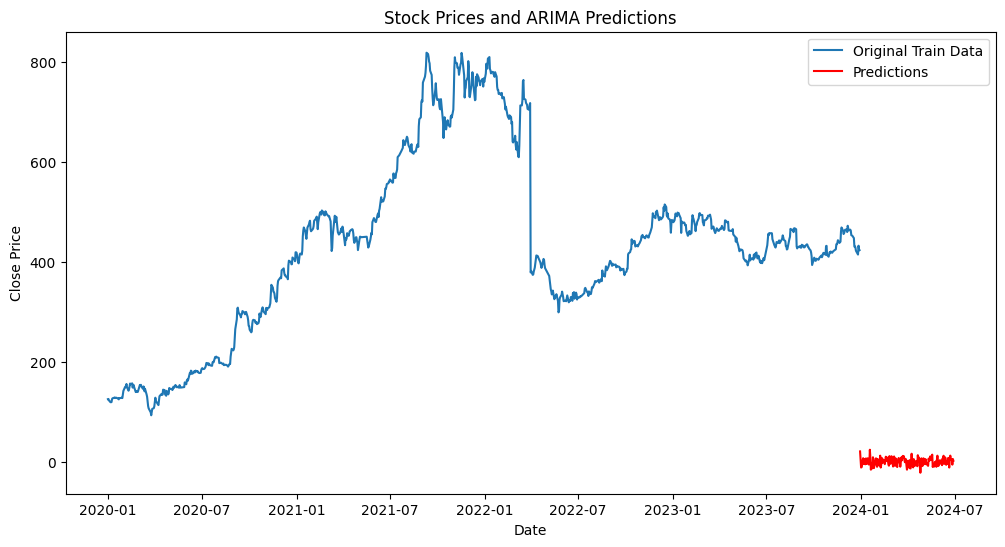

In [266]:
plt.figure(figsize=(12, 6))
plt.plot(training_data["CLOSE"], label="Original Train Data")
plt.plot(predictions, label="Predictions", color="red")
plt.title("Stock Prices and ARIMA Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

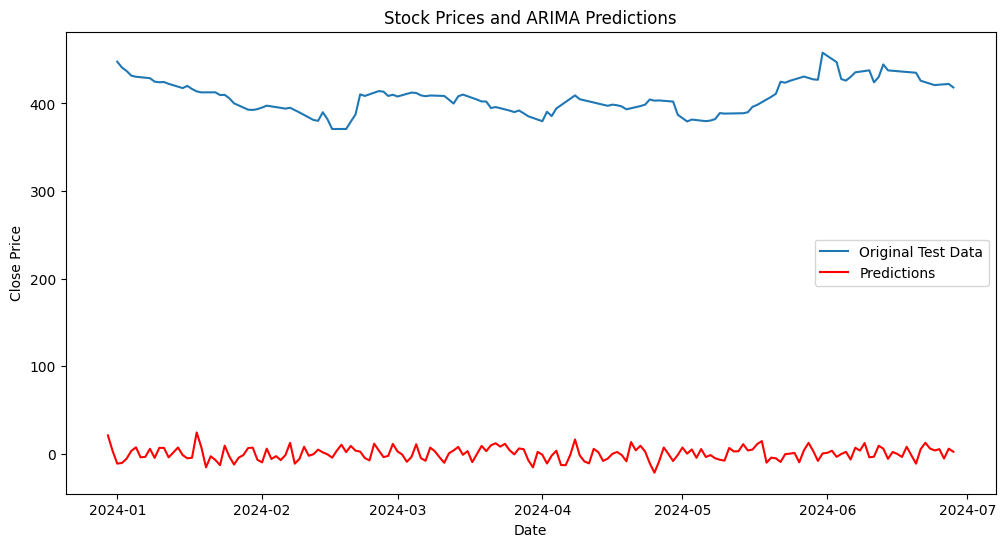

In [267]:
plt.figure(figsize=(12, 6))
plt.plot(testing_data["CLOSE"], label="Original Test Data")
plt.plot(predictions, label="Predictions", color="red")
plt.title("Stock Prices and ARIMA Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()